In [1]:
using Gen
using GenSerialization
using Plots
import Random
Random.seed!(3)

Random.TaskLocalRNG()

In [14]:
bearing(x, y) = atan(y, x)

@gen function model(T::Int)

    measurement_noise = 0.005
    velocity_var = 1e-6

    xs = Vector{Float64}(undef, T+1)
    ys = Vector{Float64}(undef, T+1)

    # prior on initial x-coordinate
    x = {:x0} ~ normal(0.01, 0.01)

    # prior on initial y-coordinate
    y = {:y0} ~ normal(0.95, 0.01)

    # prior on x-component of initial velocity
    vx = {:vx0} ~ normal(0.002, 0.01)

    # prior on y-component of initial velocity
    vy = {:vy0} ~ normal(-0.013, 0.01)

    # initial bearing measurement
    z0 ~ normal(bearing(x, y), measurement_noise)

    # record position
    xs[1] = x
    ys[1] = y

    # generate successive states and measurements
    for t=1:T

        # update the state of the point
        vx = {(:vx, t)} ~ normal(vx, sqrt(velocity_var))
        vy = {(:vy, t)} ~ normal(vy, sqrt(velocity_var))
        x += vx
        y += vy

        # bearing measurement
        {(:z, t)} ~ normal(bearing(x, y), measurement_noise)

        # record position
        xs[t+1] = x
        ys[t+1] = y
    end

    # return the sequence of positions
    return (xs, ys)
end;

function initialize(T)
    constraints = Gen.choicemap((:x0, 0.01), (:y0, 0.95), (:vx0, 0.002), (:vy0, -0.013))
    (trace, _) = Gen.generate(model, (T,), constraints)

    # extract the observed data (zs) from the trace
    choices = Gen.get_choices(trace)
    zs = Vector{Float64}(undef, T+1)
    zs[1] = choices[:z0]
    for t=1:T
        zs[t+1] = choices[(:z, t)]
    end
    zs
end

# generate trace with specific initial conditions

function render(trace; show_data=true, max_T=get_args(trace)[1], overlay=false)
    (T,) = Gen.get_args(trace)
    (xs, ys) = Gen.get_retval(trace)
    
    zs = Vector{Float64}(undef, T+1)
    zs[1] = trace[:z0]
    for t=1:T
        zs[t+1] = trace[(:z, t)]
    end
    
    f = overlay ? scatter! : scatter
    fig = f(xs[1:max_T+1], ys[1:max_T+1], s=:auto, label=nothing)
    
    if show_data
        for z in zs[1:max_T+1]
            dx = cos(z) * 0.5
            dy = sin(z) * 0.5
            plot!([0., dx], [0., dy], color="red", alpha=0.3, label=nothing)
        end
    end
    
    return fig
end;

function particle_filter(num_particles::Int, zs::Vector{Float64}, num_samples::Int)
    
    # construct initial observations
    init_obs = Gen.choicemap((:z0, zs[1]))
    state = initialize_external_memory_particle_filter(model, (0,), init_obs, num_particles)
    
    # steps
    for t=1:length(zs)-1
        # Gen.maybe_resample!(state, ess_threshold=num_particles/2)
        obs = Gen.choicemap(((:z, t), zs[t+1]))
        particle_filter_step!(state, (t,), (UnknownChange(),), obs, model)
    end
    
    # return a sample of unweighted traces from the weighted collection
    return sample_unweighted_traces(state, num_samples)
end;

In [38]:
include("external_particle_filter.jl")

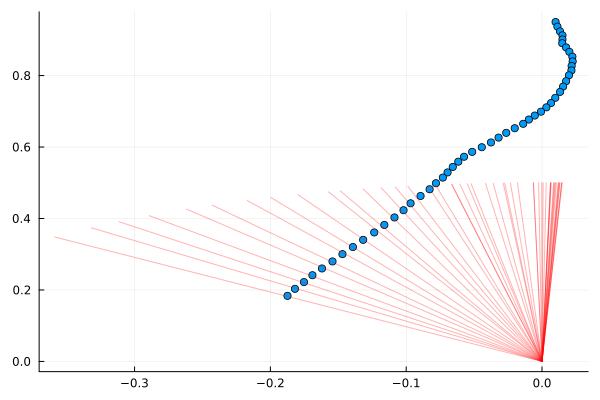

In [39]:
T = 50
constraints = Gen.choicemap((:x0, 0.01), (:y0, 0.95), (:vx0, 0.002), (:vy0, -0.013))
(trace, _) = Gen.generate(model, (T,), constraints)

# extract the observed data (zs) from the trace
choices = Gen.get_choices(trace)
zs = Vector{Float64}(undef, T+1)
zs[1] = choices[:z0]
for t=1:T
    zs[t+1] = choices[(:z, t)]
end
plot(label=nothing)
render(trace)

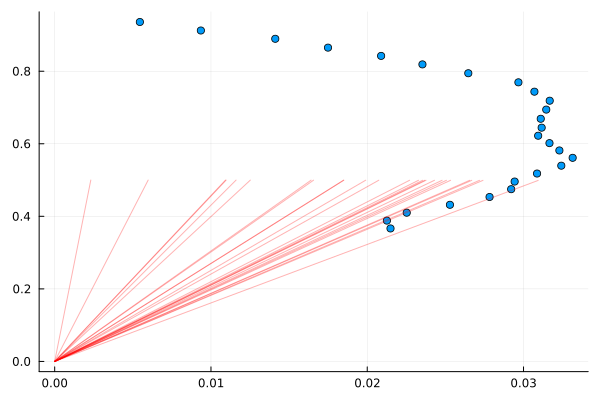

In [48]:
T = 25
zs = initialize(T)
trace = particle_filter(1000, zs, 1)[1]
plot(label=nothing)
render(trace)